In this notebook we produce an embedding using the technique of Node2vec similar to Word2vec (linguistic models). 
With this node embedding we compute the edge embedding and make a k-cross validation score against the weighted edges
of the network. 
The goal is to produce an embedding of edges that, given two nodes, provides the predicted sign of the link. 
For this purpose we have substituted the classes in the edges by only 2, positive and negative. 

In [1]:
import numpy as np
import pandas as pd 


import torch
import torch_geometric.data as data
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling,train_test_split_edges,to_dense_adj
from sklearn.metrics import roc_auc_score
from torch_geometric.transforms import RandomLinkSplit
from sklearn import preprocessing
from torch_geometric.nn import Node2Vec

device = "cpu"

In [2]:
nodes = pd.read_csv(r"Nodes_t1.csv",sep=",",encoding = 'unicode_escape')
edges = pd.read_csv(r"Edges_t1.csv",sep=",",encoding = 'unicode_escape')
edges = edges[edges["weight"]!= 1]
edges["weight"] = edges["weight"].apply(lambda x: np.sign(x))
nodes[["ID"]] = nodes[["ID"]].apply(lambda x:x-edges["from"].min())
edges[["from","to"]] = edges[["from","to"]].apply(lambda x:x-edges["from"].min())
###Erase ESO 
nodes["Curso"] = nodes["Curso"].astype(str).str[0].astype("int64")
#del nodes["Unnamed: 0"]
nodes_dummy = pd.get_dummies(nodes)
x = nodes_dummy.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
nodes_norm = pd.DataFrame(x_scaled)

In [3]:
total_data = data.Data(x=torch.tensor(nodes_norm.to_numpy(),dtype=torch.float32),
                          edge_index=torch.tensor(edges[["from","to"]].to_numpy().T),
                          edge_attr=torch.tensor((pd.get_dummies(edges["weight"]).to_numpy())))

In [4]:
total_data

Data(x=[409, 12], edge_index=[2, 3674], edge_attr=[3674, 2])

In [5]:
import random as rd

node_list = list(range(len(nodes)))
rd.shuffle(node_list)
train_set = node_list[0:round(len(node_list)*0.7)]
val_set = node_list[round(len(node_list)*0.7):round(len(node_list)*0.85)]
test_set = node_list[round(len(node_list)*0.85):round(len(node_list)*1)]
rd.shuffle(test_set)
print(len(train_set),len(test_set),len(val_set))
print(len(train_set)+len(test_set)+len(val_set) == len(node_list))

print("train set\t",train_set[:10])
print("test set \t",test_set[:10])
print("val set  \t",val_set[:10])

286 61 62
True
train set	 [82, 328, 307, 403, 195, 8, 137, 13, 254, 295]
test set 	 [243, 150, 324, 162, 102, 322, 347, 99, 337, 233]
val set  	 [331, 110, 214, 334, 209, 284, 294, 239, 37, 358]


In [6]:
# build test train val masks

train_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in train_set:
    train_mask[i] = 1.

test_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in test_set:
    test_mask[i] = 1.
    
val_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in val_set:
    val_mask[i] = 1.
    
print("train mask \t",train_mask[0:15])
print("test mask  \t",test_mask[0:15])
print("val mask   \t",val_mask[0:15]) 

train mask 	 tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0])
test mask  	 tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1])
val mask   	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [7]:
# add masks
total_data.train_mask = train_mask
total_data.test_mask = test_mask
total_data.val_mask = val_mask

print("after\t\t",total_data)

after		 Data(x=[409, 12], edge_index=[2, 3674], edge_attr=[3674, 2], train_mask=[409], test_mask=[409], val_mask=[409])


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(total_data.edge_index, embedding_dim=128, walk_length=40,
             context_size=20, walks_per_node=5,
             num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.005)


In [9]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[total_data.train_mask], total_data.y[total_data.train_mask],
                     z[total_data.test_mask], total_data.y[total_data.test_mask],
                     max_iter=10)
    return acc


for epoch in range(1, 121):
    loss = train()
    #acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
        

Epoch: 10, Loss: 5.3870
Epoch: 20, Loss: 4.1476
Epoch: 30, Loss: 3.3178
Epoch: 40, Loss: 2.6681
Epoch: 50, Loss: 2.2142
Epoch: 60, Loss: 1.8625
Epoch: 70, Loss: 1.6258
Epoch: 80, Loss: 1.4296
Epoch: 90, Loss: 1.3133
Epoch: 100, Loss: 1.1978
Epoch: 110, Loss: 1.1026
Epoch: 120, Loss: 1.0525


In [10]:
z = model()

In [11]:
# from tensor to numpy
emb_128 = z.detach().cpu().numpy()

In [12]:
# convert edge attributes from categorical to numerical
edge_attr_cat = total_data.edge_attr.numpy()
print("Categorical edge attributes:\n",edge_attr_cat[:3])

edge_attr = []
for i in edge_attr_cat:
    edge_attr.append(np.nonzero(i)[0][0])

print("\n\nNumerical edge attributes:\n",edge_attr[:3])

Categorical edge attributes:
 [[1 0]
 [1 0]
 [0 1]]


Numerical edge attributes:
 [0, 0, 1]


### Compute edge embedding

In [13]:
#edge_embedding = []
#for u,v in total_data.edge_index.t():
#    edge_embedding.append(np.mean([emb_128[u],emb_128[v]],0))
edge_embedding = []
for u,v in total_data.edge_index.t():
    edge_embedding.append(np.maximum(emb_128[u],emb_128[v]))

### Make dataframe from embedding and scale

In [14]:
emb_df = pd.concat([pd.DataFrame(edge_embedding),pd.DataFrame(edge_attr,columns=["label"])],axis=1)

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

In [16]:
X = emb_df.drop("label",axis=1)
y = emb_df["label"]

emb_x_train, emb_x_test, emb_y_train, emb_y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=emb_df["label"])

In [17]:
sc.fit(emb_x_train)
emb_x_train = sc.transform(emb_x_train)
emb_x_test = sc.transform(emb_x_test)

### Oversample minority class

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
ros = SMOTE(random_state=0,sampling_strategy="minority")
emb_x_resampled, emb_y_resampled = ros.fit_resample(emb_x_train, emb_y_train)
emb_y_resampled = emb_y_resampled.values
emb_y_test = emb_y_test.values

### Training and prediction 

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [21]:
clf = RandomForestClassifier(max_depth=7,random_state=10,class_weight="balanced")

In [22]:
clf.fit(emb_x_resampled,emb_y_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=7, random_state=10)



              precision    recall  f1-score   support

           0       0.71      0.63      0.67       251
           1       0.82      0.87      0.84       484

    accuracy                           0.79       735
   macro avg       0.77      0.75      0.76       735
weighted avg       0.78      0.79      0.78       735



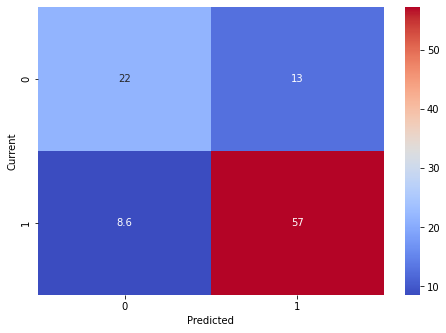

In [23]:
from sklearn.metrics import confusion_matrix,classification_report
fig= plt.figure()
ax = fig.add_axes([0,0,1,1])
sns.heatmap(np.round(confusion_matrix(emb_y_test,np.around(clf.predict(emb_x_test)))/len(emb_y_test)*100,2),
            annot=True,ax=ax,cmap="coolwarm")
ax.set_xlabel("Predicted")
ax.set_ylabel("Current")
print("\n")
print(classification_report(emb_y_test,clf.predict(emb_x_test)))


In [24]:
import tensorflow as tf

2022-03-24 16:30:00.418944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-24 16:30:00.419032: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu",input_shape=(emb_x_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=10e-5),
         loss="binary_crossentropy",
             metrics=["accuracy"])
model_history = model.fit(emb_x_resampled,emb_y_resampled,validation_data=(emb_x_test,emb_y_test),epochs=250,verbose=1,batch_size=128,
                         #callbacks=[tf.keras.callbacks.EarlyStopping(patience=25)])
                         )

Epoch 1/250
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-03-24 16:30:02.750858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-24 16:30:02.750888: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-24 16:30:02.750912: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iT28200): /proc/driver/nvidia/version does not exist
2022-03-24 16:30:02.751235: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/juan/.local/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is dep

29/31 [===========================>..] - ETA: 0s - loss: 0.7312 - accuracy: 0.5024 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fd2a4756ee0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
31/31 [==============================] - 1s 6ms/step - loss: 0.7320 - accuracy: 0.4992 - val_loss: 0.7064 - val_accuracy: 0.3510
Epoch 2/250
31/31 [==============

Epoch 52/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5129 - val_loss: 0.6943 - val_accuracy: 0.3837
Epoch 53/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5217 - val_loss: 0.6946 - val_accuracy: 0.3810
Epoch 54/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6912 - accuracy: 0.5199 - val_loss: 0.6941 - val_accuracy: 0.4068
Epoch 55/250
31/31 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5227 - val_loss: 0.6941 - val_accuracy: 0.3959
Epoch 56/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6888 - accuracy: 0.5437 - val_loss: 0.6934 - val_accuracy: 0.4517
Epoch 57/250
31/31 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5225 - val_loss: 0.6938 - val_accuracy: 0.4204
Epoch 58/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6915 - accuracy: 0.5181 - val_loss: 0.6937 - val_accuracy: 0.4354
Epoch 

31/31 [==============================] - 0s 2ms/step - loss: 0.6661 - accuracy: 0.6036 - val_loss: 0.6743 - val_accuracy: 0.6177
Epoch 110/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6694 - accuracy: 0.6023 - val_loss: 0.6678 - val_accuracy: 0.6381
Epoch 111/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.5922 - val_loss: 0.6719 - val_accuracy: 0.6204
Epoch 112/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6739 - accuracy: 0.5948 - val_loss: 0.6849 - val_accuracy: 0.5374
Epoch 113/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6671 - accuracy: 0.6010 - val_loss: 0.6691 - val_accuracy: 0.6395
Epoch 114/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6689 - accuracy: 0.5946 - val_loss: 0.6709 - val_accuracy: 0.6245
Epoch 115/250
31/31 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.5995 - val_loss: 0.6749 - val_accuracy: 0.5973
Epoch 116/250

31/31 [==============================] - 0s 2ms/step - loss: 0.6195 - accuracy: 0.6811 - val_loss: 0.6329 - val_accuracy: 0.6408
Epoch 167/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6094 - accuracy: 0.6827 - val_loss: 0.6239 - val_accuracy: 0.6531
Epoch 168/250
31/31 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6755 - val_loss: 0.6442 - val_accuracy: 0.6150
Epoch 169/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6101 - accuracy: 0.6842 - val_loss: 0.6197 - val_accuracy: 0.6585
Epoch 170/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6179 - accuracy: 0.6835 - val_loss: 0.6187 - val_accuracy: 0.6707
Epoch 171/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6121 - accuracy: 0.6922 - val_loss: 0.6220 - val_accuracy: 0.6612
Epoch 172/250
31/31 [==============================] - 0s 2ms/step - loss: 0.6157 - accuracy: 0.6806 - val_loss: 0.6300 - val_accuracy: 0.6449
Epoch 173/250

31/31 [==============================] - 0s 2ms/step - loss: 0.5590 - accuracy: 0.7398 - val_loss: 0.6050 - val_accuracy: 0.6694
Epoch 224/250
31/31 [==============================] - 0s 2ms/step - loss: 0.5550 - accuracy: 0.7385 - val_loss: 0.6020 - val_accuracy: 0.6762
Epoch 225/250
31/31 [==============================] - 0s 2ms/step - loss: 0.5711 - accuracy: 0.7207 - val_loss: 0.5987 - val_accuracy: 0.6857
Epoch 226/250
31/31 [==============================] - 0s 2ms/step - loss: 0.5689 - accuracy: 0.7284 - val_loss: 0.6338 - val_accuracy: 0.6299
Epoch 227/250
31/31 [==============================] - 0s 2ms/step - loss: 0.5686 - accuracy: 0.7307 - val_loss: 0.6003 - val_accuracy: 0.6830
Epoch 228/250
31/31 [==============================] - 0s 2ms/step - loss: 0.5517 - accuracy: 0.7279 - val_loss: 0.5964 - val_accuracy: 0.6912
Epoch 229/250
31/31 [==============================] - 0s 2ms/step - loss: 0.5590 - accuracy: 0.7323 - val_loss: 0.6159 - val_accuracy: 0.6531
Epoch 230/250

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


              precision    recall  f1-score   support

           0       0.52      0.59      0.55       251
           1       0.77      0.72      0.74       484

    accuracy                           0.67       735
   macro avg       0.65      0.65      0.65       735
weighted avg       0.69      0.67      0.68       735



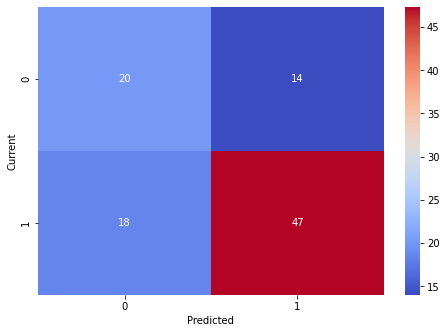

In [26]:
from sklearn.metrics import confusion_matrix,classification_report
fig= plt.figure()
ax = fig.add_axes([0,0,1,1])
sns.heatmap(np.round(confusion_matrix(emb_y_test,np.around(model.predict(emb_x_test)))/len(emb_y_test)*100,2),
            annot=True,ax=ax,cmap="coolwarm")
ax.set_xlabel("Predicted")
ax.set_ylabel("Current")
print("\n")
print(classification_report(emb_y_test,np.around(model.predict(emb_x_test))))


<AxesSubplot:>

<Figure size 864x576 with 0 Axes>

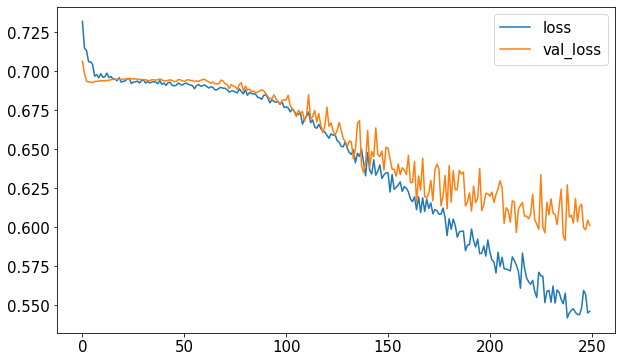

In [27]:
fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 15})
pd.DataFrame(model_history.history)[["loss","val_loss"]].plot(figsize=(10,6))

<AxesSubplot:>

<Figure size 864x576 with 0 Axes>

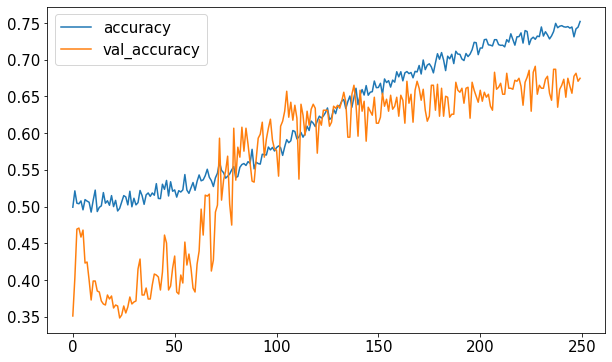

In [28]:
fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 15})
pd.DataFrame(model_history.history)[["accuracy","val_accuracy"]].plot(figsize=(10,6))

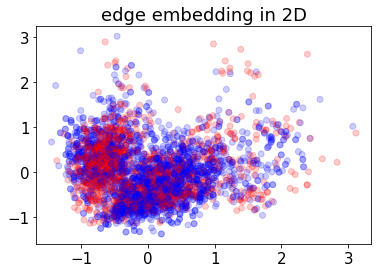

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
edge_emb2d = pca.fit_transform(edge_embedding)



df = pd.DataFrame(dict(edge_att=edge_attr))
colors = {0:"red",1:"blue"}
plt.title("edge embedding in 2D")
plt.scatter(edge_emb2d[:,0],edge_emb2d[:,1],c=df.edge_att.map(colors),alpha=0.2)
plt.show()

# not so good but we are using PCA to reduce the dim from 128 to 2